<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#[TODO]-정답-코드-구현-UNet-" data-toc-modified-id="[TODO]-정답-코드-구현-UNet--5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><font color="blue">[TODO] 정답 코드 구현 UNet </font></a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [22]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [23]:
batch_size = 4   # Mini-batch size
num_epochs = 50
learning_rate = 0.01

In [24]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [25]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


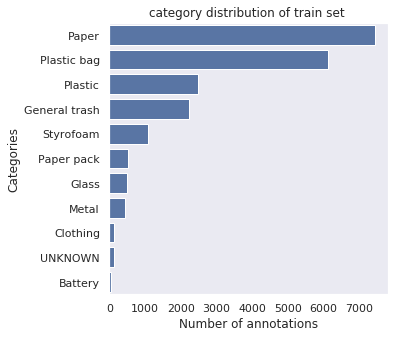

In [26]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [27]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [28]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


## 데이터 전처리 함수 정의 (Dataset)

In [29]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [30]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.96s)
creating index...
index created!
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {'Paper', 3}]


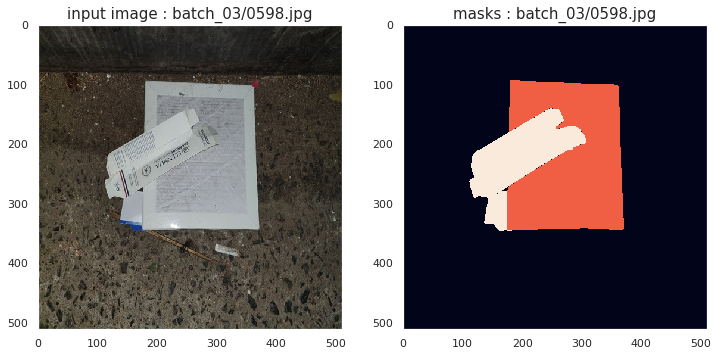

In [31]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 6}, {'Plastic', 7}, {9, 'Plastic bag'}]


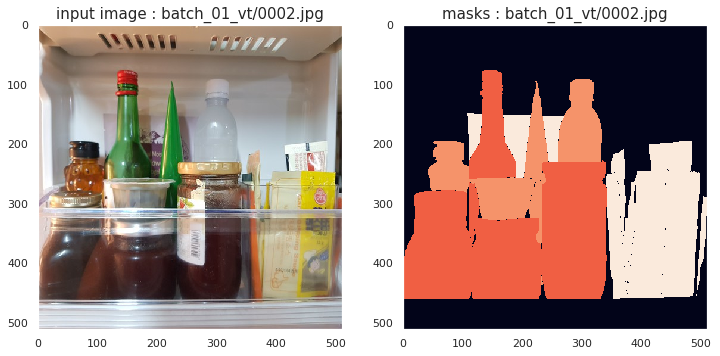

In [32]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


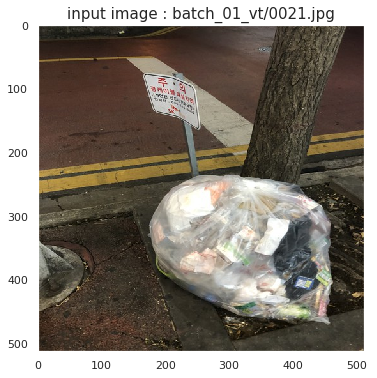

In [33]:
# test_loader의 output 결과(image 및 mask) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    # temp_masks = masks
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model


### <font color='blue'>[TODO] 정답 코드 구현 UNet </font>

In [34]:
import torch
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, num_classes=12):
        super(UNet, self).__init__()
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)
            return cbr

        # Contracting path 
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)     
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
 
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2)    

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2)    

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=True)
        self.enc5_2 = CBR2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=True)
        self.unpool4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True) 
        self.dec4_1 = CBR2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True) 

        self.unpool3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True) 
        self.dec3_1 = CBR2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True) 

        self.unpool2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)  
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)  

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True) 
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True) 
        self.score_fr = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1, stride=1, padding=0, bias=True) # Output Segmentation map 

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)

        unpool4 = self.unpool4(enc5_2)
        cat4 = torch.cat((unpool4, enc4_2), dim=1) 
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1) 
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1) 
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1) 
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        output = self.score_fr(dec1_1) 
        return output

In [35]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

model = UNet(num_classes=12)
x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


## train, validation, test 함수 정의

In [36]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        model.train()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        scheduler.step()
        print('lr : ',optimizer.param_groups[0]["lr"])
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [37]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))

    return avrg_loss

## 모델 저장 함수 정의

In [38]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='Unet_best_model.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [39]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [40]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/50], Step [25/655], Loss: 0.6949
Epoch [1/50], Step [50/655], Loss: 0.8634
Epoch [1/50], Step [75/655], Loss: 1.1145
Epoch [1/50], Step [100/655], Loss: 1.0013
Epoch [1/50], Step [125/655], Loss: 0.9312
Epoch [1/50], Step [150/655], Loss: 0.8803
Epoch [1/50], Step [175/655], Loss: 1.0337
Epoch [1/50], Step [200/655], Loss: 0.8747
Epoch [1/50], Step [225/655], Loss: 0.8995
Epoch [1/50], Step [250/655], Loss: 0.7706
Epoch [1/50], Step [275/655], Loss: 0.6690
Epoch [1/50], Step [300/655], Loss: 1.0749
Epoch [1/50], Step [325/655], Loss: 1.5026
Epoch [1/50], Step [350/655], Loss: 0.9321
Epoch [1/50], Step [375/655], Loss: 0.7071
Epoch [1/50], Step [400/655], Loss: 0.6484
Epoch [1/50], Step [425/655], Loss: 1.6274
Epoch [1/50], Step [450/655], Loss: 1.0833
Epoch [1/50], Step [475/655], Loss: 0.6971
Epoch [1/50], Step [500/655], Loss: 1.1503
Epoch [1/50], Step [525/655], Loss: 1.7296
Epoch [1/50], Step [550/655], Loss: 0.8954
Epoch [1/50], Step [575/655], Loss: 1.47

## 저장된 model 불러오기 (학습된 이후) 

In [41]:
# best model 저장된 경로
model_path = './saved/Unet_best_model.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

<All keys matched successfully>

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {'Paper', 3}, {'Plastic', 7}, {8, 'Styrofoam'}, {9, 'Plastic bag'}]


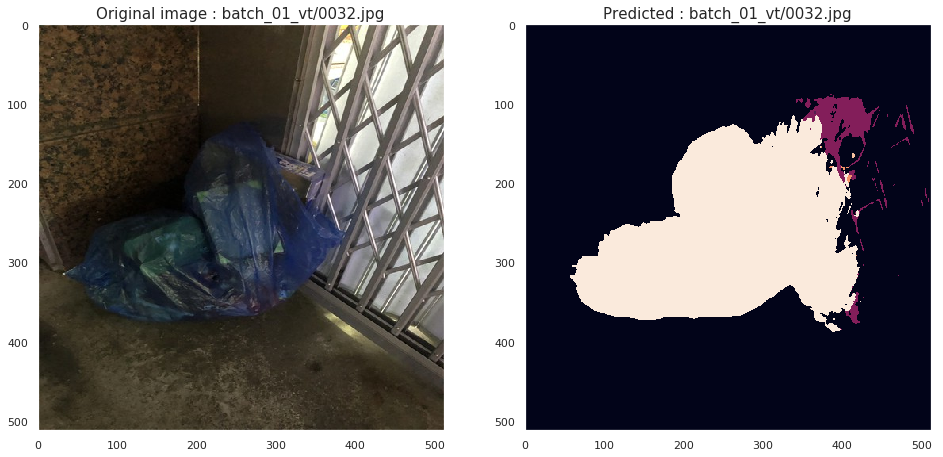

In [42]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [43]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(data_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [44]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/Baseline_UNet.csv", index=False)

Start prediction.
End prediction.


## Reference

